In [1]:
import os
import numpy as np 
import pandas as pd
import seaborn
import seaborn as sns
import shap # for SHAP value
import random
import warnings
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from bs4 import BeautifulSoup
import re

# The Natural Language Toolkit, or more commonly NLTK, is a suite of libraries and programs for symbolic and 
# statistical natural language processing for English written in the Python programming language.
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


#TQDM is a progress bar library with good support for nested loops and Jupyter/IPython notebooks.
from tqdm import tqdm


# Use Keras Tensorflow deeplearning library

from tensorflow import set_random_seed

from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential


from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.metrics import roc_curve,auc,make_scorer, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



import eli5 # for permutation importance
from eli5.sklearn import PermutationImportance

from pdpbox import pdp, info_plots # flor partial plots 

from scipy import interp

from itertools import cycle

from joblib import dump, load
seed_value = 123
os.environ['PYTHONHASHSEED']=str(seed_value)

Using TensorFlow backend.


In [2]:
os.getcwd()
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [3]:
set_random_seed(123)
random.seed(123)

In [4]:
np.random.seed(123)
pd.options.mode.chained_assignment = None  #hide any pandas warnings
%matplotlib inline

In [5]:
train= pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

In [6]:
# Train dataset: Need only class as "Sentiment" and text as 'Phrase'
train = train.rename(columns={'class':'Sentiment','tweet':'Phrase'})
train = train.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'],axis=1).copy()

In [7]:
# Test dataset: Need only text as 'Phrase'
test = test.rename(columns={'Text':'Phrase'})
test = test.drop(['Date', 'Favorites', 'Retweets', 'Tweet ID'],axis=1).copy()


In [8]:
# Need to Save the split texts before cleaning and tokenizing
# Collect dependent values and convert to ONE-HOT encoding
# Output using to_categorical
target_t = train.Sentiment.values
y_target_t = to_categorical(target_t)

# Save the texts before tokenizing (must use the same random seed)
X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(train,y_target_t,
                                                          test_size=0.2,
                                                          random_state=seed_value,
                                                          stratify=y_target_t)

In [9]:
def clean_sentences(df):
    tweets = []
    
#     for sent in tqdm(df['Phrase']):
    for sent in df['Phrase']:
        # remove non-alphabetic characters
        tweet_text = re.sub("[^a-zA-Z]"," ", str(sent))
        
        #remove html content
        tweet_text = BeautifulSoup(tweet_text).get_text()
        
        # tokenize
        words = word_tokenize(tweet_text.lower())
        
        # lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        
        tweets.append(lemma_words)
        
    return(tweets)

In [10]:
# cleaned tweets for both train and test set retrieved

train_sentences = clean_sentences(train)

test_sentences = clean_sentences(test)

In [11]:
# Collect dependent values and convert to ONE-HOT encoding
# Output using to_categorical
target = train.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

In [12]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_sentences,
                                                  y_target,
                                                  test_size=0.2,
                                                  random_state=seed_value,
                                                  stratify=y_target)

In [13]:
# Getting the no of unique words and max length of a tweet available in the list of cleaned tweets
# It is needed for initializing tokenizer of keras and subsequent padding

# Build an unordered collection of unique elements.
unique_words = set()
len_max = 0

# for sent in tqdm(X_train):
for sent in X_train:

    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max=len(sent)

# length of the list of unique_words gives the number of unique words

unique_words_count = len(list(unique_words))

In [14]:
# Actual tokenizer of keras and convert to sequences

tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

# texts_to_sequences
# ARGUMENTS: list of texts to turn to sequences
# RETURN: list of sequences (one per text input)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

In [15]:
# Padding is done to equalize the lengths of all input tweets.
# LTSM networks need all inputs to be same length.
# Therefore, tweets lesser than max length will be made equal using extra zeros at end. This is padding.
# Also, you always have to give a three-dimensional array as an input to your LSTM network

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

In [16]:
# Early stopping to prevent overfitting deep learning neural network models
# This is a method that allows you to specify an arbitrary large number of training epochs.
# This stops training once the model performance stops improving on a hold out validation dataset

early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor = 'val_acc', patience = 2)
callback = [early_stopping]

In [17]:
# Create the model

model = Sequential()
model.add(Embedding(unique_words_count,300,input_length=len_max))
model.add(LSTM(128,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5,recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu')) #try elu
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(optimizer=Adam(lr=0.005),
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

W0804 13:08:37.500938 4457424320 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 13:08:37.503137 4457424320 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 13:08:37.505349 4457424320 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 13:08:37.579957 4457424320 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0804 13:08:37.586821 4457424320 deprecati

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 53, 300)           8641200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 53, 128)           219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 8,917,059
Trainable params: 8,917,059
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Count of number of data points in each category
hate_ct = y_train.sum(axis = 0)[0]
offensive_ct = y_train.sum(axis = 0)[1]
neither_ct = y_train.sum(axis = 0)[2]
total_ct = y_train.sum()

In [19]:
# Calculating the inverse ratio of each category to use for the weights of the model
inv_ratio_hate = 1 - (hate_ct / total_ct)
inv_ratio_hurtful = 1 - (offensive_ct / total_ct)
inv_ratio_neither = 1 - (neither_ct / total_ct)

In [20]:
# fit the model adjusting for epochs, batch, and weight

model.fit(
    X_train, y_train, 
    validation_data=(X_val,y_val),
    epochs=15, #may not run all due to callback
    batch_size=256, #faster with larger batch_size but it's generalizing
    verbose=1,
    callbacks=callback, #stops training once the model stops improving. Prevents overfitting.
    class_weight={0: inv_ratio_hate,
                  1: inv_ratio_hurtful,
                  2: inv_ratio_neither} #use inverse ratio to set hate with highest weight (somewhat arbitrary)
) 

W0804 13:08:38.372256 4457424320 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 19822 samples, validate on 4956 samples
Epoch 1/15
19822/19822 [==============================] - 44s 2ms/step - loss: 0.2466 - acc: 0.8151 - val_loss: 0.4067 - val_acc: 0.8878
Epoch 2/15
19822/19822 [==============================] - 42s 2ms/step - loss: 0.1358 - acc: 0.8922 - val_loss: 0.3467 - val_acc: 0.8856
Epoch 3/15
19822/19822 [==============================] - 42s 2ms/step - loss: 0.0854 - acc: 0.9243 - val_loss: 0.3401 - val_acc: 0.8820


In [21]:
# Predict validation sentiment!
y_pred = model.predict(X_val)

In [22]:
# Keras and Sklearn read arrays differently
# Create function to convert keras array to show only one highest sentiment result per list
def keras_output_sklearn(y):
    
    result = []
    
    for element in y:
        result.append(np.argmax(element))
        

    return result

In [23]:
# Saving model
model.save('../models/LSTM_model.h5')

## How did the Model Do?

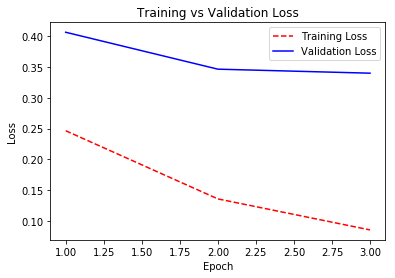

In [24]:
# Create count of the number of epochs
epoch_count = range(1,len(model.history.history['loss']) + 1)

# Visualize the learning curve.

plt.plot(epoch_count,model.history.history['loss'],'r--')
plt.plot(epoch_count,model.history.history['val_loss'],'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')

# save figure
plt.savefig('../model_reports/loss.png')

plt.show()

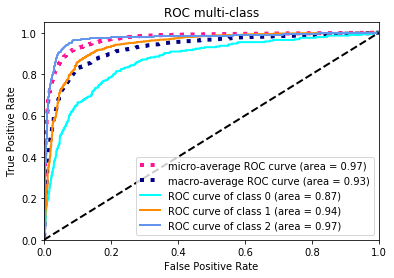

In [25]:
# Use trained Keras model to predict test inputs and generate ROC data
# Plot ROC for each of the 3 classes

# Plot linewidth.
lw = 2

# 3 classes to classify
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC multi-class')
plt.legend(loc="lower right")

# Save figure
plt.savefig('../model_reports/roc.png')

plt.show()

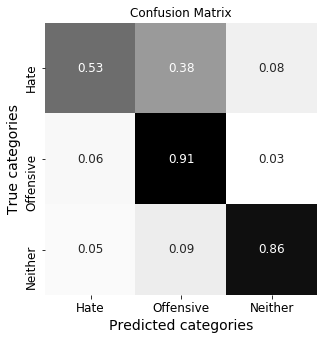

In [26]:
# Use seaborn to see counts in percentages
# Truth categories yield 100%
confusion_matrix_t = confusion_matrix(keras_output_sklearn(y_val),keras_output_sklearn(y_pred))

matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix_t[i,:]/float(confusion_matrix_t[i,:].sum())
names=['Hate','Offensive','Neither']
# save result as pandas df
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.title('Confusion Matrix')
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
plt.savefig('../model_reports/confusion.png')

In [27]:
print(classification_report(keras_output_sklearn(y_val), keras_output_sklearn(y_pred)))

              precision    recall  f1-score   support

           0       0.37      0.53      0.44       286
           1       0.95      0.91      0.93      3838
           2       0.84      0.86      0.85       832

   micro avg       0.88      0.88      0.88      4956
   macro avg       0.72      0.77      0.74      4956
weighted avg       0.90      0.88      0.89      4956

